<a href="https://colab.research.google.com/github/RangerCoF/SparseConv/blob/main/Caltech101/Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import tarfile
import gzip
import requests
import os

In [ ]:
def download_file(url, save_path):
    # Send a request
    response = requests.get(url, stream=True)
    # Check the response status code
    if response.status_code == 200:
        # Open the file in binary write mode
        with open(save_path, 'wb') as f:
            # Write the file chunk by chunk
            for chunk in response.iter_content(chunk_size=128):
                f.write(chunk)
        print("File downloaded successfully")
    else:
        print("Download failed. Status code:", response.status_code)

def extract_tar(file_path, extract_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist")
        return

    # Extract .tar file
    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=extract_path)
    print(f"Extracted '{file_path}' to '{extract_path}'")

def extract_tar_gz(file_path, extract_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File '{file_path}' does not exist")
        return

    # Extract .tar.gz file
    with gzip.open(file_path, 'rb') as gz:
        with tarfile.open(fileobj=gz, mode='r') as tar:
            tar.extractall(path=extract_path)
    print(f"Extracted '{file_path}' to '{extract_path}'")

In [ ]:
caltech101_url = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1'
download_path = '/content/downloads'
caltech101_path = download_path + '/caltech-101.zip'

if not os.path.exists(download_path):
  os.makedirs(download_path)

download_file(caltech101_url, caltech101_path)

File downloaded successfully


In [ ]:
extract_path = download_path + '/extract'
if not os.path.exists(extract_path):
  os.makedirs(extract_path)
with zipfile.ZipFile(caltech101_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
dataset_path = '/content/data'
if not os.path.exists(dataset_path):
  os.makedirs(dataset_path)
extract_tar_gz(extract_path + '/caltech-101/101_ObjectCategories.tar.gz', dataset_path)

Extracted '/content/downloads/extract/caltech-101/101_ObjectCategories.tar.gz' to '/content/data'


In [ ]:
image_path = dataset_path + '/101_ObjectCategories'

label_list = os.listdir(image_path)
label_list = [item for item in label_list if item!='BACKGROUND_Google']
label_path = [image_path + '/' + item for item in label_list]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("device=cuda")
else:
    device = torch.device("cpu")
    print("device=cpu")

device=cuda


In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [ ]:
images = []
labels = []

for i in range(len(label_path)):
  folder_path = label_path[i]
#for folder_path in label_path:
  for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    #print(file_path)
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
      img = Image.open(file_path)
      if img.mode != 'RGB':
        img = img.convert('RGB')
      img_transformed = transform(img)
      images.append(img_transformed)
      labels.append(i)

labels = torch.tensor(labels)
train_data, test_data, train_targets, test_targets = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
class SparseConvNetDataset(Dataset):
  def __init__(self, data, targets, device, mask):
    self.data = data.copy()
    self.targets = targets
    self.mask = mask
    if type(mask) != int:
        for i in range(len(self.data)):
            self.data[i] = self.data[i] * mask[i]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = torch.cat((self.data[idx], self.mask[idx].unsqueeze(0)), dim=0)
    data = data.to(device)
    targets = self.targets[idx].to(device)
    return data, targets

In [ ]:
class ConvBlock(nn.Module):
  def __init__(
      self,
      in_channels,
      out_channels,
      kernel_size,
      stride=1,
      padding='same',
      dilation=1):
    super(ConvBlock, self).__init__()

    self.conv = nn.Conv2d(
      in_channels=in_channels,
      out_channels=out_channels,
      kernel_size=kernel_size,
      stride=stride,
      padding=padding,
      dilation=dilation,
      bias=False)

    self.relu = nn.ReLU(inplace=True)
    self.pool = nn.MaxPool2d(2, 2)
    self.norm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.norm(x)
    return x

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
      super(ConvNet, self).__init__()
      self.conv1 = ConvBlock(3, 6, 7, padding='same')
      self.conv2 = ConvBlock(6, 16, 5, padding='same')
      self.conv3 = ConvBlock(16, 16, 3, padding='same')
      self.conv4 = ConvBlock(16, 16, 3, padding='same')

      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(16 * 14 * 14, 240)
      self.fc2 = nn.Linear(240, 120)
      self.fc3 = nn.Linear(120, 101)

    def forward(self, x):
      x = x[:, :-1, :, :]
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)

      x = self.flatten(x)
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [ ]:
def model_test(model, testloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

In [ ]:
prob = 0.0
batch_size = 64

train_mask = torch.bernoulli(torch.full(torch.Size([len(train_data)]) + train_data[0].shape[1:], 1 - float(prob)))
test_mask = torch.bernoulli(torch.full(torch.Size([len(test_data)]) + test_data[0].shape[1:], 1 - float(prob)))

trainset = SparseConvNetDataset(train_data, train_targets, device, train_mask)
testset = SparseConvNetDataset(test_data, test_targets, device, test_mask)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

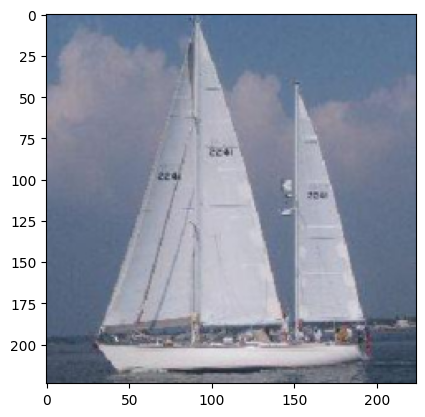

In [ ]:
plt.imshow(testset[0][0][:3].cpu().permute(1, 2, 0))

In [ ]:
net = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
acc_conv = []

for epoch in tqdm(range(50)):
    if epoch==25:
          optimizer = optim.Adam(net.parameters(), lr=0.0001)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

      inputs, labels = data
      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if i % 20 == 19:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
    acc_conv.append(model_test(net, testloader))
    print('acc: %.3f' % acc_conv[epoch])
print('Finished Training')

  0%|          | 0/50 [00:00<?, ?it/s]

[1,    20] loss: 3.84163
[1,    40] loss: 3.18213
[1,    60] loss: 2.77874
[1,    80] loss: 2.59199
[1,   100] loss: 2.48720


  2%|▏         | 1/50 [00:09<07:49,  9.59s/it]

acc: 0.474
[2,    20] loss: 1.80328
[2,    40] loss: 1.58052
[2,    60] loss: 1.54660
[2,    80] loss: 1.58294
[2,   100] loss: 1.58907


  4%|▍         | 2/50 [00:18<07:26,  9.31s/it]

acc: 0.560
[3,    20] loss: 0.84823
[3,    40] loss: 0.85966
[3,    60] loss: 0.84645
[3,    80] loss: 0.87756
[3,   100] loss: 0.78102


  6%|▌         | 3/50 [00:27<07:09,  9.13s/it]

acc: 0.615
[4,    20] loss: 0.35628
[4,    40] loss: 0.29651
[4,    60] loss: 0.33973
[4,    80] loss: 0.29689
[4,   100] loss: 0.35368


  8%|▊         | 4/50 [00:36<06:58,  9.10s/it]

acc: 0.622
[5,    20] loss: 0.13547
[5,    40] loss: 0.10174
[5,    60] loss: 0.09382
[5,    80] loss: 0.10113
[5,   100] loss: 0.12592


 10%|█         | 5/50 [00:45<06:50,  9.12s/it]

acc: 0.651
[6,    20] loss: 0.03610
[6,    40] loss: 0.02921
[6,    60] loss: 0.02508
[6,    80] loss: 0.03194
[6,   100] loss: 0.02524


 12%|█▏        | 6/50 [00:55<06:44,  9.19s/it]

acc: 0.659
[7,    20] loss: 0.01369
[7,    40] loss: 0.01130
[7,    60] loss: 0.01027
[7,    80] loss: 0.00722
[7,   100] loss: 0.01260


 14%|█▍        | 7/50 [01:04<06:35,  9.21s/it]

acc: 0.660
[8,    20] loss: 0.00499
[8,    40] loss: 0.01949
[8,    60] loss: 0.00409
[8,    80] loss: 0.00779
[8,   100] loss: 0.00442


 16%|█▌        | 8/50 [01:13<06:26,  9.21s/it]

acc: 0.667
[9,    20] loss: 0.00254
[9,    40] loss: 0.00242
[9,    60] loss: 0.00210
[9,    80] loss: 0.00238
[9,   100] loss: 0.00444


 18%|█▊        | 9/50 [01:22<06:17,  9.21s/it]

acc: 0.662
[10,    20] loss: 0.00226
[10,    40] loss: 0.00744
[10,    60] loss: 0.00258
[10,    80] loss: 0.00246
[10,   100] loss: 0.01163


 20%|██        | 10/50 [01:31<06:03,  9.09s/it]

acc: 0.668
[11,    20] loss: 0.00207
[11,    40] loss: 0.00467
[11,    60] loss: 0.00990
[11,    80] loss: 0.00193
[11,   100] loss: 0.00486


 22%|██▏       | 11/50 [01:40<05:52,  9.05s/it]

acc: 0.673
[12,    20] loss: 0.00139
[12,    40] loss: 0.00143
[12,    60] loss: 0.00117
[12,    80] loss: 0.00597
[12,   100] loss: 0.00629


 24%|██▍       | 12/50 [01:49<05:45,  9.09s/it]

acc: 0.674
[13,    20] loss: 0.00121
[13,    40] loss: 0.00109
[13,    60] loss: 0.00372
[13,    80] loss: 0.00685
[13,   100] loss: 0.00267


 26%|██▌       | 13/50 [01:58<05:35,  9.08s/it]

acc: 0.671
[14,    20] loss: 0.00093
[14,    40] loss: 0.00361
[14,    60] loss: 0.00317
[14,    80] loss: 0.00092
[14,   100] loss: 0.00279


 28%|██▊       | 14/50 [02:08<05:28,  9.13s/it]

acc: 0.671
[15,    20] loss: 0.00152
[15,    40] loss: 0.00241
[15,    60] loss: 0.00090
[15,    80] loss: 0.00076
[15,   100] loss: 0.00298


 30%|███       | 15/50 [02:17<05:18,  9.11s/it]

acc: 0.672
[16,    20] loss: 0.00081
[16,    40] loss: 0.00339
[16,    60] loss: 0.00263
[16,    80] loss: 0.00082
[16,   100] loss: 0.00063


 32%|███▏      | 16/50 [02:26<05:08,  9.09s/it]

acc: 0.672
[17,    20] loss: 0.00060
[17,    40] loss: 0.00065
[17,    60] loss: 0.00063
[17,    80] loss: 0.00226
[17,   100] loss: 0.00250


 34%|███▍      | 17/50 [02:35<05:00,  9.11s/it]

acc: 0.673
[18,    20] loss: 0.00118
[18,    40] loss: 0.00235
[18,    60] loss: 0.00064
[18,    80] loss: 0.00060
[18,   100] loss: 0.00381


 36%|███▌      | 18/50 [02:44<04:51,  9.10s/it]

acc: 0.671
[19,    20] loss: 0.00055
[19,    40] loss: 0.00066
[19,    60] loss: 0.00110
[19,    80] loss: 0.00048
[19,   100] loss: 0.00325


 38%|███▊      | 19/50 [02:53<04:41,  9.07s/it]

acc: 0.671
[20,    20] loss: 0.00063
[20,    40] loss: 0.00241
[20,    60] loss: 0.00054
[20,    80] loss: 0.00048
[20,   100] loss: 0.00241


 40%|████      | 20/50 [03:02<04:31,  9.06s/it]

acc: 0.675
[21,    20] loss: 0.00088
[21,    40] loss: 0.00267
[21,    60] loss: 0.00176
[21,    80] loss: 0.00049
[21,   100] loss: 0.00044


 42%|████▏     | 21/50 [03:11<04:22,  9.05s/it]

acc: 0.677
[22,    20] loss: 0.00067
[22,    40] loss: 0.00198
[22,    60] loss: 0.00057
[22,    80] loss: 0.00035
[22,   100] loss: 0.00250


 44%|████▍     | 22/50 [03:20<04:14,  9.10s/it]

acc: 0.673
[23,    20] loss: 0.00033
[23,    40] loss: 0.00264
[23,    60] loss: 0.00178
[23,    80] loss: 0.00037
[23,   100] loss: 0.00034


 46%|████▌     | 23/50 [03:29<04:05,  9.08s/it]

acc: 0.676
[24,    20] loss: 0.00205
[24,    40] loss: 0.00033
[24,    60] loss: 0.00037
[24,    80] loss: 0.00152
[24,   100] loss: 0.00181


 48%|████▊     | 24/50 [03:38<03:55,  9.04s/it]

acc: 0.678
[25,    20] loss: 0.00030
[25,    40] loss: 0.00028
[25,    60] loss: 0.00128
[25,    80] loss: 0.00248
[25,   100] loss: 0.00028


 50%|█████     | 25/50 [03:47<03:46,  9.05s/it]

acc: 0.676
[26,    20] loss: 0.00062
[26,    40] loss: 0.00076
[26,    60] loss: 0.00154
[26,    80] loss: 0.00027
[26,   100] loss: 0.00028


 52%|█████▏    | 26/50 [03:56<03:36,  9.02s/it]

acc: 0.671
[27,    20] loss: 0.00076
[27,    40] loss: 0.00082
[27,    60] loss: 0.00018
[27,    80] loss: 0.00017
[27,   100] loss: 0.00243


 54%|█████▍    | 27/50 [04:05<03:27,  9.01s/it]

acc: 0.677
[28,    20] loss: 0.00076
[28,    40] loss: 0.00014
[28,    60] loss: 0.00011
[28,    80] loss: 0.00173
[28,   100] loss: 0.00098


 56%|█████▌    | 28/50 [04:14<03:18,  9.02s/it]

acc: 0.672
[29,    20] loss: 0.00144
[29,    40] loss: 0.00042
[29,    60] loss: 0.00009
[29,    80] loss: 0.00008
[29,   100] loss: 0.00166


 58%|█████▊    | 29/50 [04:23<03:09,  9.03s/it]

acc: 0.679
[30,    20] loss: 0.00096
[30,    40] loss: 0.00046
[30,    60] loss: 0.00007
[30,    80] loss: 0.00111
[30,   100] loss: 0.00007


 60%|██████    | 30/50 [04:32<03:00,  9.03s/it]

acc: 0.682
[31,    20] loss: 0.00007
[31,    40] loss: 0.00015
[31,    60] loss: 0.00568
[31,    80] loss: 0.00463
[31,   100] loss: 0.00300


 62%|██████▏   | 31/50 [04:41<02:51,  9.03s/it]

acc: 0.660
[32,    20] loss: 0.00042
[32,    40] loss: 0.00227
[32,    60] loss: 0.00070
[32,    80] loss: 0.00019
[32,   100] loss: 0.00016


 64%|██████▍   | 32/50 [04:50<02:42,  9.04s/it]

acc: 0.671
[33,    20] loss: 0.00012
[33,    40] loss: 0.00015
[33,    60] loss: 0.00072
[33,    80] loss: 0.00011
[33,   100] loss: 0.00137


 66%|██████▌   | 33/50 [04:59<02:33,  9.02s/it]

acc: 0.676
[34,    20] loss: 0.00008
[34,    40] loss: 0.00071
[34,    60] loss: 0.00010
[34,    80] loss: 0.00192
[34,   100] loss: 0.00009


 68%|██████▊   | 34/50 [05:08<02:24,  9.02s/it]

acc: 0.675
[35,    20] loss: 0.00009
[35,    40] loss: 0.00120
[35,    60] loss: 0.00065
[35,    80] loss: 0.00008
[35,   100] loss: 0.00095


 70%|███████   | 35/50 [05:17<02:15,  9.03s/it]

acc: 0.676
[36,    20] loss: 0.00054
[36,    40] loss: 0.00054
[36,    60] loss: 0.00089
[36,    80] loss: 0.00007
[36,   100] loss: 0.00007


 72%|███████▏  | 36/50 [05:26<02:06,  9.03s/it]

acc: 0.675
[37,    20] loss: 0.00006
[37,    40] loss: 0.00056
[37,    60] loss: 0.00129
[37,    80] loss: 0.00007
[37,   100] loss: 0.00089


 74%|███████▍  | 37/50 [05:36<01:57,  9.03s/it]

acc: 0.676
[38,    20] loss: 0.00006
[38,    40] loss: 0.00056
[38,    60] loss: 0.00052
[38,    80] loss: 0.00149
[38,   100] loss: 0.00006


 76%|███████▌  | 38/50 [05:44<01:48,  9.01s/it]

acc: 0.677
[39,    20] loss: 0.00120
[39,    40] loss: 0.00083
[39,    60] loss: 0.00005
[39,    80] loss: 0.00077
[39,   100] loss: 0.00006


 78%|███████▊  | 39/50 [05:54<01:39,  9.01s/it]

acc: 0.679
[40,    20] loss: 0.00129
[40,    40] loss: 0.00075
[40,    60] loss: 0.00071
[40,    80] loss: 0.00005
[40,   100] loss: 0.00005


 80%|████████  | 40/50 [06:03<01:30,  9.06s/it]

acc: 0.677
[41,    20] loss: 0.00005
[41,    40] loss: 0.00075
[41,    60] loss: 0.00124
[41,    80] loss: 0.00069
[41,   100] loss: 0.00005


 82%|████████▏ | 41/50 [06:12<01:21,  9.02s/it]

acc: 0.677
[42,    20] loss: 0.00050
[42,    40] loss: 0.00004
[42,    60] loss: 0.00087
[42,    80] loss: 0.00052
[42,   100] loss: 0.00077


 84%|████████▍ | 42/50 [06:21<01:12,  9.03s/it]

acc: 0.677
[43,    20] loss: 0.00052
[43,    40] loss: 0.00004
[43,    60] loss: 0.00148
[43,    80] loss: 0.00004
[43,   100] loss: 0.00072


 86%|████████▌ | 43/50 [06:30<01:03,  9.03s/it]

acc: 0.678
[44,    20] loss: 0.00169
[44,    40] loss: 0.00004
[44,    60] loss: 0.00004
[44,    80] loss: 0.00112
[44,   100] loss: 0.00004


 88%|████████▊ | 44/50 [06:39<00:54,  9.01s/it]

acc: 0.675
[45,    20] loss: 0.00003
[45,    40] loss: 0.00116
[45,    60] loss: 0.00004
[45,    80] loss: 0.00088
[45,   100] loss: 0.00003


 90%|█████████ | 45/50 [06:48<00:45,  9.03s/it]

acc: 0.676
[46,    20] loss: 0.00004
[46,    40] loss: 0.00003
[46,    60] loss: 0.00070
[46,    80] loss: 0.00004
[46,   100] loss: 0.00067


 92%|█████████▏| 46/50 [06:57<00:36,  9.01s/it]

acc: 0.673
[47,    20] loss: 0.00003
[47,    40] loss: 0.00004
[47,    60] loss: 0.00056
[47,    80] loss: 0.00130
[47,   100] loss: 0.00074


 94%|█████████▍| 47/50 [07:06<00:27,  9.02s/it]

acc: 0.679
[48,    20] loss: 0.00003
[48,    40] loss: 0.00003
[48,    60] loss: 0.00053
[48,    80] loss: 0.00051
[48,   100] loss: 0.00158


 96%|█████████▌| 48/50 [07:15<00:18,  9.09s/it]

acc: 0.679
[49,    20] loss: 0.00004
[49,    40] loss: 0.00057
[49,    60] loss: 0.00046
[49,    80] loss: 0.00003
[49,   100] loss: 0.00003


 98%|█████████▊| 49/50 [07:24<00:09,  9.08s/it]

acc: 0.679
[50,    20] loss: 0.00062
[50,    40] loss: 0.00135
[50,    60] loss: 0.00064
[50,    80] loss: 0.00003
[50,   100] loss: 0.00003


100%|██████████| 50/50 [07:33<00:00,  9.07s/it]

acc: 0.677
Finished Training


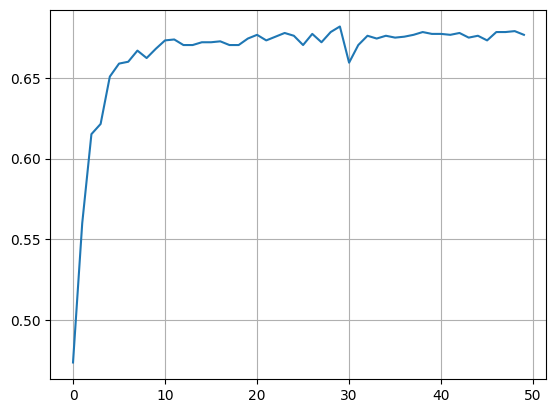

In [ ]:
plt.plot(acc_conv)
plt.grid()

  0%|          | 0/20 [00:00<?, ?it/s]

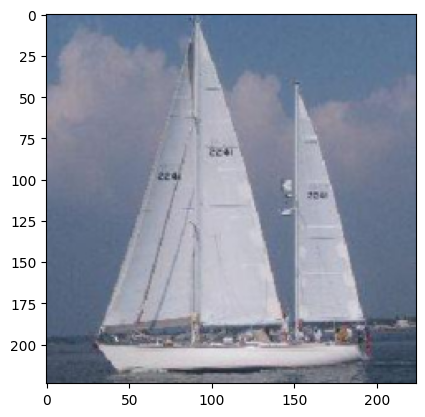

loss: 2.92278
[Sparsity: 0.00, Epoch: 1]acc: 0.450
loss: 1.57812
[Sparsity: 0.00, Epoch: 2]acc: 0.576
loss: 0.76982
[Sparsity: 0.00, Epoch: 3]acc: 0.604
loss: 0.27760
[Sparsity: 0.00, Epoch: 4]acc: 0.603
loss: 0.07173
[Sparsity: 0.00, Epoch: 5]acc: 0.633
loss: 0.01622
[Sparsity: 0.00, Epoch: 6]acc: 0.664
loss: 0.00759
[Sparsity: 0.00, Epoch: 7]acc: 0.668
loss: 0.00561
[Sparsity: 0.00, Epoch: 8]acc: 0.668
loss: 0.00453
[Sparsity: 0.00, Epoch: 9]acc: 0.673
loss: 0.00454
[Sparsity: 0.00, Epoch: 10]acc: 0.674
Finished Training


  5%|▌         | 1/20 [01:36<30:24, 96.05s/it]

[Sparsity: 0.00]acc: 0.674


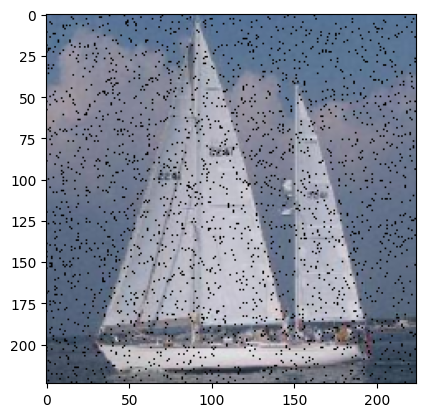

loss: 2.99194
[Sparsity: 0.05, Epoch: 1]acc: 0.442
loss: 1.76080
[Sparsity: 0.05, Epoch: 2]acc: 0.541
loss: 0.98969
[Sparsity: 0.05, Epoch: 3]acc: 0.531
loss: 0.41695
[Sparsity: 0.05, Epoch: 4]acc: 0.608
loss: 0.15005
[Sparsity: 0.05, Epoch: 5]acc: 0.621
loss: 0.02871
[Sparsity: 0.05, Epoch: 6]acc: 0.624
loss: 0.01198
[Sparsity: 0.05, Epoch: 7]acc: 0.638
loss: 0.00795
[Sparsity: 0.05, Epoch: 8]acc: 0.632
loss: 0.00684
[Sparsity: 0.05, Epoch: 9]acc: 0.639
loss: 0.00567
[Sparsity: 0.05, Epoch: 10]acc: 0.639
Finished Training


 10%|█         | 2/20 [03:11<28:41, 95.62s/it]

[Sparsity: 0.05]acc: 0.639


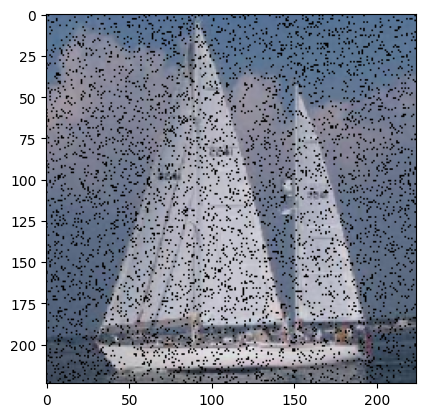

loss: 2.99804
[Sparsity: 0.10, Epoch: 1]acc: 0.444
loss: 1.68202
[Sparsity: 0.10, Epoch: 2]acc: 0.461
loss: 0.83876
[Sparsity: 0.10, Epoch: 3]acc: 0.582
loss: 0.30316
[Sparsity: 0.10, Epoch: 4]acc: 0.609
loss: 0.08089
[Sparsity: 0.10, Epoch: 5]acc: 0.627
loss: 0.01646
[Sparsity: 0.10, Epoch: 6]acc: 0.645
loss: 0.00761
[Sparsity: 0.10, Epoch: 7]acc: 0.643
loss: 0.00477
[Sparsity: 0.10, Epoch: 8]acc: 0.651
loss: 0.00369
[Sparsity: 0.10, Epoch: 9]acc: 0.647
loss: 0.00274
[Sparsity: 0.10, Epoch: 10]acc: 0.651
Finished Training


 15%|█▌        | 3/20 [04:47<27:07, 95.72s/it]

[Sparsity: 0.10]acc: 0.651


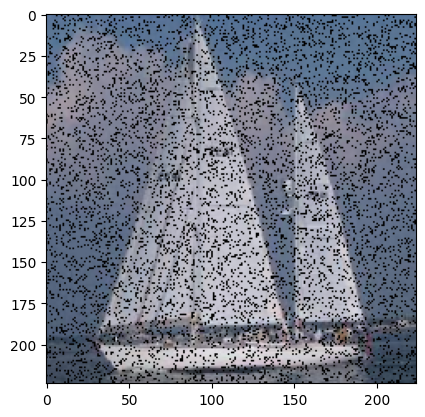

loss: 3.05913
[Sparsity: 0.15, Epoch: 1]acc: 0.419
loss: 1.74357
[Sparsity: 0.15, Epoch: 2]acc: 0.535
loss: 0.91684
[Sparsity: 0.15, Epoch: 3]acc: 0.584
loss: 0.36024
[Sparsity: 0.15, Epoch: 4]acc: 0.609
loss: 0.09960
[Sparsity: 0.15, Epoch: 5]acc: 0.628
loss: 0.01922
[Sparsity: 0.15, Epoch: 6]acc: 0.652
loss: 0.00906
[Sparsity: 0.15, Epoch: 7]acc: 0.649
loss: 0.00528
[Sparsity: 0.15, Epoch: 8]acc: 0.657
loss: 0.00379
[Sparsity: 0.15, Epoch: 9]acc: 0.656
loss: 0.00292
[Sparsity: 0.15, Epoch: 10]acc: 0.653
Finished Training


 20%|██        | 4/20 [06:24<25:41, 96.37s/it]

[Sparsity: 0.15]acc: 0.653


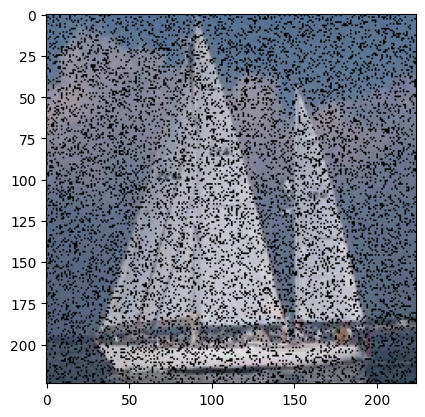

loss: 3.02639
[Sparsity: 0.20, Epoch: 1]acc: 0.452
loss: 1.73188
[Sparsity: 0.20, Epoch: 2]acc: 0.523
loss: 0.92953
[Sparsity: 0.20, Epoch: 3]acc: 0.581
loss: 0.37947
[Sparsity: 0.20, Epoch: 4]acc: 0.593
loss: 0.11208
[Sparsity: 0.20, Epoch: 5]acc: 0.595
loss: 0.01987
[Sparsity: 0.20, Epoch: 6]acc: 0.622
loss: 0.00819
[Sparsity: 0.20, Epoch: 7]acc: 0.628
loss: 0.00558
[Sparsity: 0.20, Epoch: 8]acc: 0.627
loss: 0.00392
[Sparsity: 0.20, Epoch: 9]acc: 0.630
loss: 0.00303
[Sparsity: 0.20, Epoch: 10]acc: 0.631
Finished Training


 25%|██▌       | 5/20 [08:01<24:10, 96.67s/it]

[Sparsity: 0.20]acc: 0.631


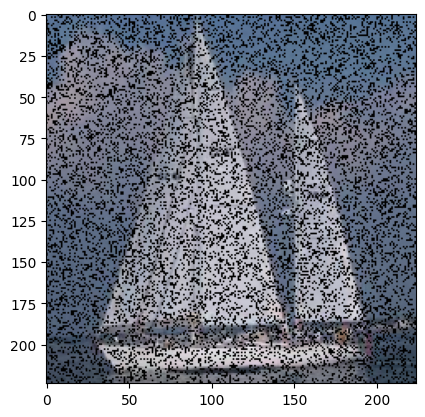

loss: 3.13287
[Sparsity: 0.25, Epoch: 1]acc: 0.440
loss: 1.95763
[Sparsity: 0.25, Epoch: 2]acc: 0.519
loss: 1.13352
[Sparsity: 0.25, Epoch: 3]acc: 0.552
loss: 0.49691
[Sparsity: 0.25, Epoch: 4]acc: 0.581
loss: 0.16380
[Sparsity: 0.25, Epoch: 5]acc: 0.586
loss: 0.02612
[Sparsity: 0.25, Epoch: 6]acc: 0.605
loss: 0.01101
[Sparsity: 0.25, Epoch: 7]acc: 0.606
loss: 0.00731
[Sparsity: 0.25, Epoch: 8]acc: 0.608
loss: 0.00519
[Sparsity: 0.25, Epoch: 9]acc: 0.609
loss: 0.00406
[Sparsity: 0.25, Epoch: 10]acc: 0.611
Finished Training


 30%|███       | 6/20 [09:41<22:45, 97.54s/it]

[Sparsity: 0.25]acc: 0.611


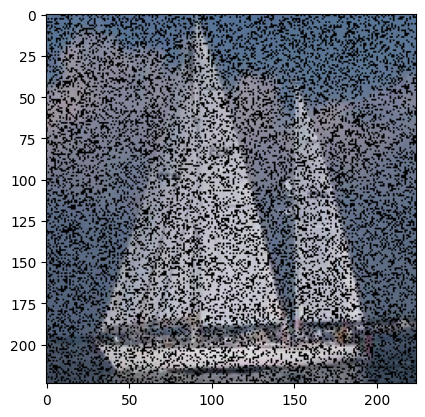

loss: 3.09605
[Sparsity: 0.30, Epoch: 1]acc: 0.426
loss: 1.91438
[Sparsity: 0.30, Epoch: 2]acc: 0.512
loss: 1.13575
[Sparsity: 0.30, Epoch: 3]acc: 0.569
loss: 0.50315
[Sparsity: 0.30, Epoch: 4]acc: 0.568
loss: 0.16381
[Sparsity: 0.30, Epoch: 5]acc: 0.607
loss: 0.02912
[Sparsity: 0.30, Epoch: 6]acc: 0.622
loss: 0.01204
[Sparsity: 0.30, Epoch: 7]acc: 0.631
loss: 0.00806
[Sparsity: 0.30, Epoch: 8]acc: 0.631
loss: 0.00586
[Sparsity: 0.30, Epoch: 9]acc: 0.631
loss: 0.00445
[Sparsity: 0.30, Epoch: 10]acc: 0.634
Finished Training


 35%|███▌      | 7/20 [11:18<21:07, 97.52s/it]

[Sparsity: 0.30]acc: 0.634


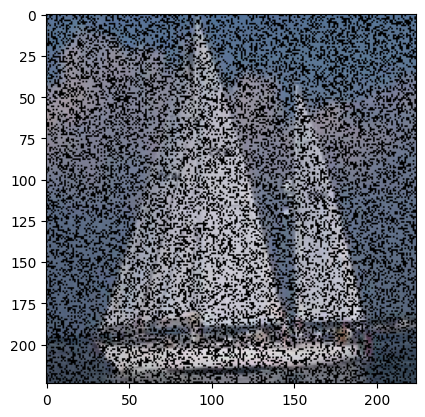

loss: 3.09988
[Sparsity: 0.35, Epoch: 1]acc: 0.408
loss: 1.88923
[Sparsity: 0.35, Epoch: 2]acc: 0.524
loss: 1.04928
[Sparsity: 0.35, Epoch: 3]acc: 0.547
loss: 0.44088
[Sparsity: 0.35, Epoch: 4]acc: 0.561
loss: 0.13244
[Sparsity: 0.35, Epoch: 5]acc: 0.585
loss: 0.02238
[Sparsity: 0.35, Epoch: 6]acc: 0.608
loss: 0.00920
[Sparsity: 0.35, Epoch: 7]acc: 0.607
loss: 0.00601
[Sparsity: 0.35, Epoch: 8]acc: 0.609
loss: 0.00441
[Sparsity: 0.35, Epoch: 9]acc: 0.611
loss: 0.00341
[Sparsity: 0.35, Epoch: 10]acc: 0.611
Finished Training


 40%|████      | 8/20 [12:57<19:35, 97.94s/it]

[Sparsity: 0.35]acc: 0.611


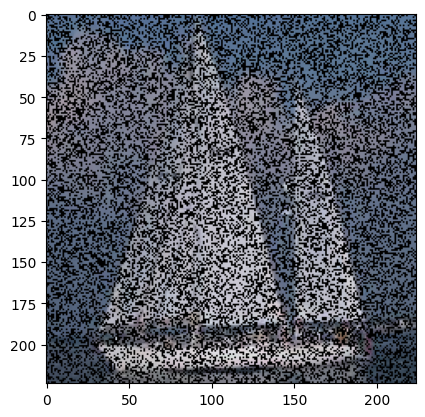

loss: 3.19358
[Sparsity: 0.40, Epoch: 1]acc: 0.423
loss: 2.02715
[Sparsity: 0.40, Epoch: 2]acc: 0.513
loss: 1.20023
[Sparsity: 0.40, Epoch: 3]acc: 0.527
loss: 0.57107
[Sparsity: 0.40, Epoch: 4]acc: 0.569
loss: 0.17213
[Sparsity: 0.40, Epoch: 5]acc: 0.580
loss: 0.02960
[Sparsity: 0.40, Epoch: 6]acc: 0.589
loss: 0.01243
[Sparsity: 0.40, Epoch: 7]acc: 0.589
loss: 0.00807
[Sparsity: 0.40, Epoch: 8]acc: 0.589
loss: 0.00577
[Sparsity: 0.40, Epoch: 9]acc: 0.592
loss: 0.00451
[Sparsity: 0.40, Epoch: 10]acc: 0.595
Finished Training


 45%|████▌     | 9/20 [14:36<18:02, 98.44s/it]

[Sparsity: 0.40]acc: 0.595


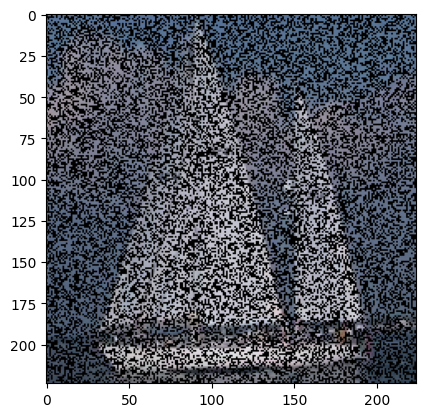

loss: 3.11205
[Sparsity: 0.45, Epoch: 1]acc: 0.448
loss: 1.94560
[Sparsity: 0.45, Epoch: 2]acc: 0.525
loss: 1.13750
[Sparsity: 0.45, Epoch: 3]acc: 0.528
loss: 0.53527
[Sparsity: 0.45, Epoch: 4]acc: 0.578
loss: 0.17879
[Sparsity: 0.45, Epoch: 5]acc: 0.570
loss: 0.03733
[Sparsity: 0.45, Epoch: 6]acc: 0.600
loss: 0.01547
[Sparsity: 0.45, Epoch: 7]acc: 0.596
loss: 0.00998
[Sparsity: 0.45, Epoch: 8]acc: 0.603
loss: 0.00717
[Sparsity: 0.45, Epoch: 9]acc: 0.603
loss: 0.00549
[Sparsity: 0.45, Epoch: 10]acc: 0.603
Finished Training


 50%|█████     | 10/20 [16:16<16:27, 98.77s/it]

[Sparsity: 0.45]acc: 0.603


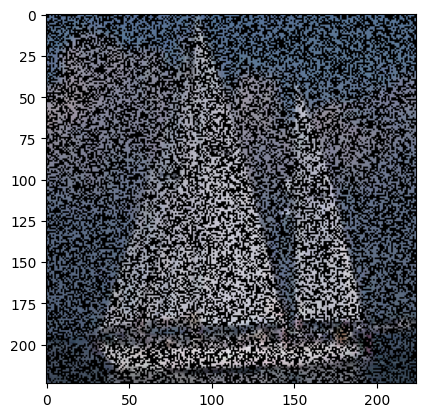

loss: 3.23243
[Sparsity: 0.50, Epoch: 1]acc: 0.429
loss: 2.05633
[Sparsity: 0.50, Epoch: 2]acc: 0.516
loss: 1.22528
[Sparsity: 0.50, Epoch: 3]acc: 0.537
loss: 0.57191
[Sparsity: 0.50, Epoch: 4]acc: 0.549
loss: 0.18223
[Sparsity: 0.50, Epoch: 5]acc: 0.552
loss: 0.03302
[Sparsity: 0.50, Epoch: 6]acc: 0.589
loss: 0.01473
[Sparsity: 0.50, Epoch: 7]acc: 0.592
loss: 0.00979
[Sparsity: 0.50, Epoch: 8]acc: 0.594
loss: 0.00704
[Sparsity: 0.50, Epoch: 9]acc: 0.594
loss: 0.00533
[Sparsity: 0.50, Epoch: 10]acc: 0.593
Finished Training


 55%|█████▌    | 11/20 [17:56<14:52, 99.13s/it]

[Sparsity: 0.50]acc: 0.593


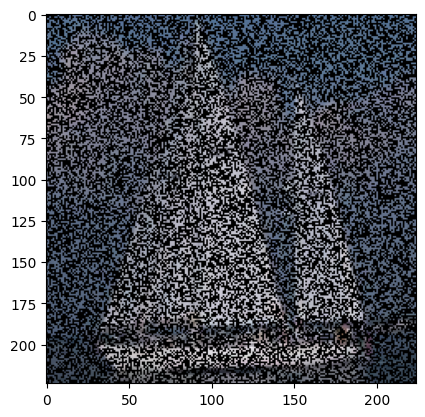

loss: 3.10030
[Sparsity: 0.55, Epoch: 1]acc: 0.427
loss: 1.94967
[Sparsity: 0.55, Epoch: 2]acc: 0.532
loss: 1.13286
[Sparsity: 0.55, Epoch: 3]acc: 0.533
loss: 0.50001
[Sparsity: 0.55, Epoch: 4]acc: 0.584
loss: 0.15772
[Sparsity: 0.55, Epoch: 5]acc: 0.577
loss: 0.02855
[Sparsity: 0.55, Epoch: 6]acc: 0.594
loss: 0.01199
[Sparsity: 0.55, Epoch: 7]acc: 0.601
loss: 0.00770
[Sparsity: 0.55, Epoch: 8]acc: 0.600
loss: 0.00574
[Sparsity: 0.55, Epoch: 9]acc: 0.603
loss: 0.00438
[Sparsity: 0.55, Epoch: 10]acc: 0.600
Finished Training


 60%|██████    | 12/20 [19:36<13:15, 99.47s/it]

[Sparsity: 0.55]acc: 0.600


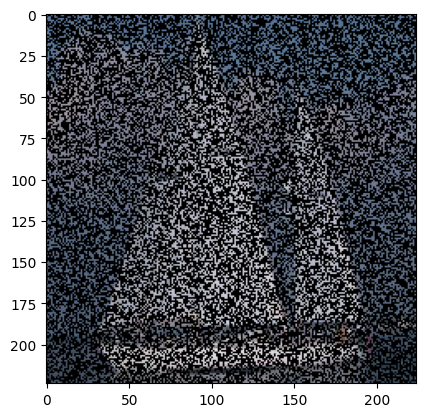

loss: 3.16507
[Sparsity: 0.60, Epoch: 1]acc: 0.422
loss: 2.00386
[Sparsity: 0.60, Epoch: 2]acc: 0.526
loss: 1.21393
[Sparsity: 0.60, Epoch: 3]acc: 0.553
loss: 0.59953
[Sparsity: 0.60, Epoch: 4]acc: 0.547
loss: 0.19429
[Sparsity: 0.60, Epoch: 5]acc: 0.571
loss: 0.03504
[Sparsity: 0.60, Epoch: 6]acc: 0.578
loss: 0.01524
[Sparsity: 0.60, Epoch: 7]acc: 0.584
loss: 0.00989
[Sparsity: 0.60, Epoch: 8]acc: 0.582
loss: 0.00720
[Sparsity: 0.60, Epoch: 9]acc: 0.584
loss: 0.00547
[Sparsity: 0.60, Epoch: 10]acc: 0.588
Finished Training


 65%|██████▌   | 13/20 [21:15<11:35, 99.37s/it]

[Sparsity: 0.60]acc: 0.588


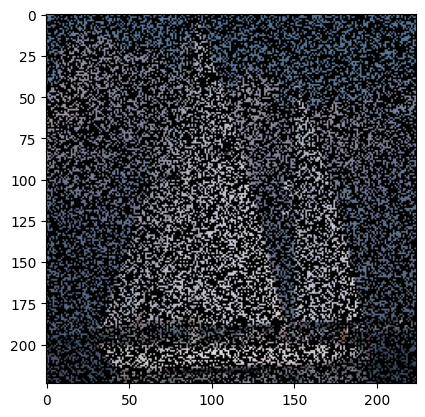

loss: 3.23446
[Sparsity: 0.65, Epoch: 1]acc: 0.408
loss: 2.11767
[Sparsity: 0.65, Epoch: 2]acc: 0.484
loss: 1.35585
[Sparsity: 0.65, Epoch: 3]acc: 0.535
loss: 0.69474
[Sparsity: 0.65, Epoch: 4]acc: 0.545
loss: 0.27616
[Sparsity: 0.65, Epoch: 5]acc: 0.550
loss: 0.05131
[Sparsity: 0.65, Epoch: 6]acc: 0.574
loss: 0.02262
[Sparsity: 0.65, Epoch: 7]acc: 0.574
loss: 0.01452
[Sparsity: 0.65, Epoch: 8]acc: 0.574
loss: 0.00991
[Sparsity: 0.65, Epoch: 9]acc: 0.573
loss: 0.00777
[Sparsity: 0.65, Epoch: 10]acc: 0.574
Finished Training


 70%|███████   | 14/20 [22:54<09:56, 99.34s/it]

[Sparsity: 0.65]acc: 0.574


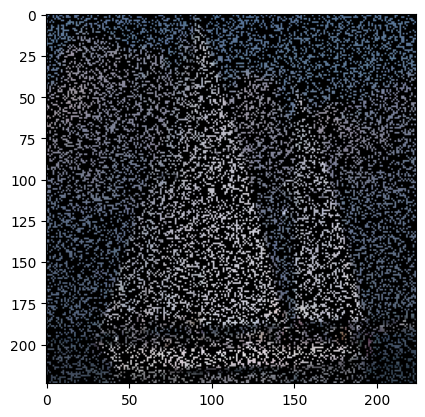

loss: 3.21208
[Sparsity: 0.70, Epoch: 1]acc: 0.412
loss: 2.13181
[Sparsity: 0.70, Epoch: 2]acc: 0.470
loss: 1.40119
[Sparsity: 0.70, Epoch: 3]acc: 0.533
loss: 0.74839
[Sparsity: 0.70, Epoch: 4]acc: 0.540
loss: 0.29105
[Sparsity: 0.70, Epoch: 5]acc: 0.536
loss: 0.05619
[Sparsity: 0.70, Epoch: 6]acc: 0.565
loss: 0.02592
[Sparsity: 0.70, Epoch: 7]acc: 0.569
loss: 0.01649
[Sparsity: 0.70, Epoch: 8]acc: 0.566
loss: 0.01150
[Sparsity: 0.70, Epoch: 9]acc: 0.566
loss: 0.00860
[Sparsity: 0.70, Epoch: 10]acc: 0.573
Finished Training


 75%|███████▌  | 15/20 [24:31<08:12, 98.43s/it]

[Sparsity: 0.70]acc: 0.573


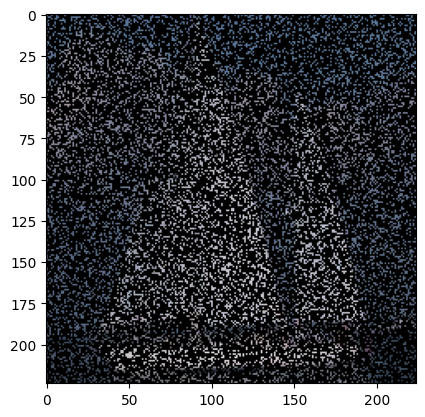

loss: 3.30206
[Sparsity: 0.75, Epoch: 1]acc: 0.395
loss: 2.15147
[Sparsity: 0.75, Epoch: 2]acc: 0.479
loss: 1.34082
[Sparsity: 0.75, Epoch: 3]acc: 0.518
loss: 0.65208
[Sparsity: 0.75, Epoch: 4]acc: 0.537
loss: 0.20428
[Sparsity: 0.75, Epoch: 5]acc: 0.539
loss: 0.03402
[Sparsity: 0.75, Epoch: 6]acc: 0.562
loss: 0.01461
[Sparsity: 0.75, Epoch: 7]acc: 0.567
loss: 0.00944
[Sparsity: 0.75, Epoch: 8]acc: 0.566
loss: 0.00702
[Sparsity: 0.75, Epoch: 9]acc: 0.568
loss: 0.00513
[Sparsity: 0.75, Epoch: 10]acc: 0.572
Finished Training


 80%|████████  | 16/20 [26:07<06:31, 97.83s/it]

[Sparsity: 0.75]acc: 0.572


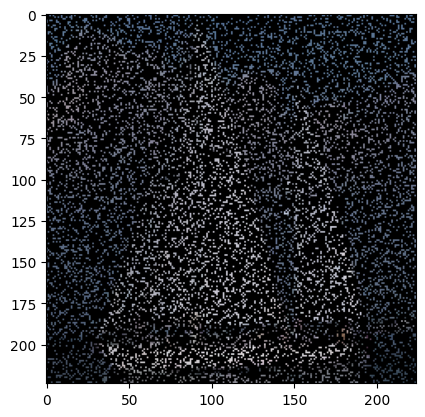

loss: 3.22124
[Sparsity: 0.80, Epoch: 1]acc: 0.409
loss: 2.10825
[Sparsity: 0.80, Epoch: 2]acc: 0.488
loss: 1.32138
[Sparsity: 0.80, Epoch: 3]acc: 0.503
loss: 0.64642
[Sparsity: 0.80, Epoch: 4]acc: 0.496
loss: 0.22524
[Sparsity: 0.80, Epoch: 5]acc: 0.520
loss: 0.03759
[Sparsity: 0.80, Epoch: 6]acc: 0.546
loss: 0.01660
[Sparsity: 0.80, Epoch: 7]acc: 0.545
loss: 0.01102
[Sparsity: 0.80, Epoch: 8]acc: 0.549
loss: 0.00765
[Sparsity: 0.80, Epoch: 9]acc: 0.546
loss: 0.00609
[Sparsity: 0.80, Epoch: 10]acc: 0.548
Finished Training


 85%|████████▌ | 17/20 [27:44<04:52, 97.54s/it]

[Sparsity: 0.80]acc: 0.548


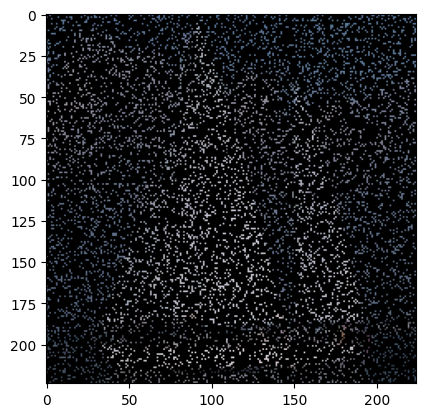

loss: 3.20726
[Sparsity: 0.85, Epoch: 1]acc: 0.408
loss: 2.13009
[Sparsity: 0.85, Epoch: 2]acc: 0.472
loss: 1.33035
[Sparsity: 0.85, Epoch: 3]acc: 0.499
loss: 0.65074
[Sparsity: 0.85, Epoch: 4]acc: 0.487
loss: 0.18973
[Sparsity: 0.85, Epoch: 5]acc: 0.520
loss: 0.03390
[Sparsity: 0.85, Epoch: 6]acc: 0.536
loss: 0.01484
[Sparsity: 0.85, Epoch: 7]acc: 0.543
loss: 0.01003
[Sparsity: 0.85, Epoch: 8]acc: 0.544
loss: 0.00676
[Sparsity: 0.85, Epoch: 9]acc: 0.548
loss: 0.00527
[Sparsity: 0.85, Epoch: 10]acc: 0.546
Finished Training


 90%|█████████ | 18/20 [29:21<03:14, 97.38s/it]

[Sparsity: 0.85]acc: 0.546


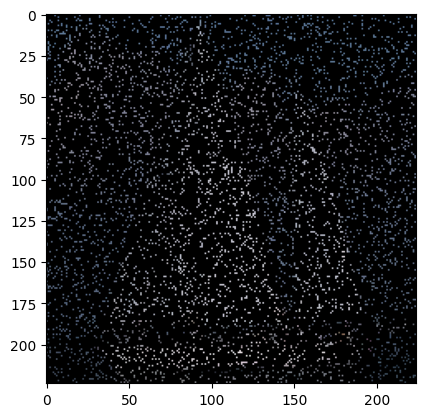

loss: 3.28038
[Sparsity: 0.90, Epoch: 1]acc: 0.397
loss: 2.20674
[Sparsity: 0.90, Epoch: 2]acc: 0.464
loss: 1.43375
[Sparsity: 0.90, Epoch: 3]acc: 0.487
loss: 0.77124
[Sparsity: 0.90, Epoch: 4]acc: 0.495
loss: 0.27714
[Sparsity: 0.90, Epoch: 5]acc: 0.497
loss: 0.05147
[Sparsity: 0.90, Epoch: 6]acc: 0.514
loss: 0.02369
[Sparsity: 0.90, Epoch: 7]acc: 0.513
loss: 0.01529
[Sparsity: 0.90, Epoch: 8]acc: 0.510
loss: 0.01116
[Sparsity: 0.90, Epoch: 9]acc: 0.514
loss: 0.00820
[Sparsity: 0.90, Epoch: 10]acc: 0.512
Finished Training


 95%|█████████▌| 19/20 [30:56<01:36, 96.51s/it]

[Sparsity: 0.90]acc: 0.512


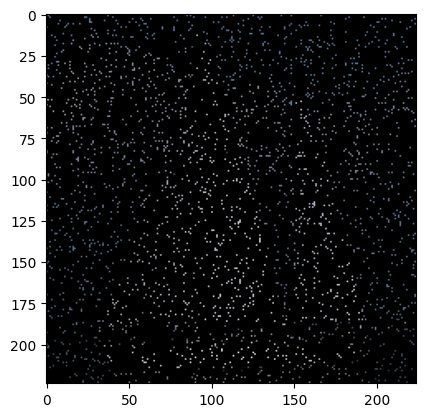

loss: 3.30706
[Sparsity: 0.95, Epoch: 1]acc: 0.384
loss: 2.29198
[Sparsity: 0.95, Epoch: 2]acc: 0.463
loss: 1.54316
[Sparsity: 0.95, Epoch: 3]acc: 0.479
loss: 0.86600
[Sparsity: 0.95, Epoch: 4]acc: 0.478
loss: 0.32108
[Sparsity: 0.95, Epoch: 5]acc: 0.479
loss: 0.06011
[Sparsity: 0.95, Epoch: 6]acc: 0.501
loss: 0.02722
[Sparsity: 0.95, Epoch: 7]acc: 0.503
loss: 0.01743
[Sparsity: 0.95, Epoch: 8]acc: 0.501
loss: 0.01246
[Sparsity: 0.95, Epoch: 9]acc: 0.503
loss: 0.00939
[Sparsity: 0.95, Epoch: 10]acc: 0.500
Finished Training


100%|██████████| 20/20 [32:31<00:00, 97.59s/it]

[Sparsity: 0.95]acc: 0.500


In [ ]:
prob_list = np.arange(0.0, 1.0, 0.05)
acc_conv = []
batch_size = 64

for prob in tqdm(prob_list):
  train_mask = torch.bernoulli(torch.full(torch.Size([len(train_data)]) + train_data[0].shape[1:], 1 - float(prob)))
  test_mask = torch.bernoulli(torch.full(torch.Size([len(test_data)]) + test_data[0].shape[1:], 1 - float(prob)))


  trainset = SparseConvNetDataset(train_data, train_targets, device, train_mask)
  testset = SparseConvNetDataset(test_data, test_targets, device, test_mask)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
  plt.imshow(testset[0][0][:3].detach().cpu().permute(1, 2, 0))
  plt.show()

  net = ConvNet().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  for epoch in range(10):
      if epoch==5:
            optimizer = optim.Adam(net.parameters(), lr=0.0001)
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # if i % 20 == 19:
        #       print('[%d, %5d] loss: %.5f' %
        #             (epoch + 1, i + 1, running_loss / 20))
        #       running_loss = 0.0
      print('loss: %.5f' % (running_loss / i))
      running_loss = 0.0
      print('[Sparsity: %.2f, Epoch: %d]acc: %.3f' % (prob, epoch + 1, model_test(net, testloader)))

  print('Finished Training')
  acc_conv.append(model_test(net, testloader))
  print('[Sparsity: %.2f]acc: %.3f' % (prob, acc_conv[-1]))

In [ ]:
print(acc_conv)

[0.673963133640553, 0.6394009216589862, 0.6509216589861752, 0.6532258064516129, 0.631336405529954, 0.6111751152073732, 0.6342165898617511, 0.6111751152073732, 0.5950460829493087, 0.603110599078341, 0.592741935483871, 0.6002304147465438, 0.5881336405529954, 0.5737327188940092, 0.5725806451612904, 0.5720046082949308, 0.5483870967741935, 0.5460829493087558, 0.511520737327189, 0.5]


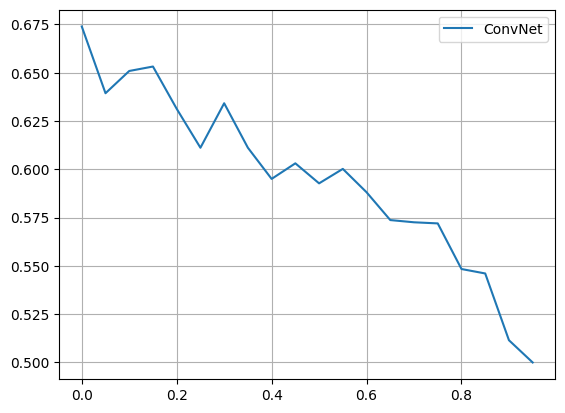

In [ ]:
plt.plot(prob_list, acc_conv, label='ConvNet')
plt.grid()
plt.legend()